Setup

In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.preprocessing import OrdinalEncoder

tfds.disable_progress_bar()

Import matplotlib and create a helper function to plot graphs

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Read the cleaned data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
training_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_dataset.csv',encoding='latin1')
training_data['CleanTweet'].replace('', np.nan, inplace=True)
training_data.dropna(subset=['CleanTweet'], inplace=True)

testing_data = pd.read_csv('/content/drive/MyDrive/final_dataset_test.csv',encoding='latin1')
testing_data['CleanTweet'].replace('', np.nan, inplace=True)
testing_data.dropna(subset=['CleanTweet'], inplace=True)

In [5]:
training_data.info()
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41113 entries, 1 to 41156
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          41113 non-null  int64 
 1   UserName       41113 non-null  int64 
 2   ScreenName     41113 non-null  int64 
 3   Location       32536 non-null  object
 4   TweetAt        41113 non-null  object
 5   OriginalTweet  41113 non-null  object
 6   Sentiment      41113 non-null  object
 7   CleanTweet     41113 non-null  object
 8   Url            41113 non-null  object
 9   Tag            41113 non-null  object
 10  Mention        41113 non-null  object
 11  Num_AT         41113 non-null  int64 
 12  Num_EX         41113 non-null  int64 
 13  Num_HPLink     41113 non-null  int64 
 14  Num_Q          41113 non-null  int64 
 15  Num_TAG        41113 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3795 entries, 0 t

Create a new column named Sentiment_id that uses number to represent sentiment

In [6]:
cat = list(np.array(['Extremely Negative','Negative', 'Neutral', 'Positive','Extremely Positive']).reshape(1,5))
ordenc = OrdinalEncoder(categories=cat)
training_sentiment = np.array(training_data.Sentiment).reshape(-1, 1)
training_data['Sentiment_id'] = ordenc.fit_transform(training_sentiment)
training_data['Sentiment_id'] = training_data['Sentiment_id'].replace({0:0, 1:0.5, 2:1, 3:1.5, 4:2})

testing_sentiment = np.array(testing_data.Sentiment).reshape(-1, 1)
testing_data['Sentiment_id'] = ordenc.fit_transform(testing_sentiment)
testing_data['Sentiment_id'] = testing_data['Sentiment_id'].replace({0:0, 1:0.5, 2:1, 3:1.5, 4:2})

In [7]:
train_x_text = training_data['CleanTweet']
train_x_num = training_data[['Num_AT','Num_EX','Num_HPLink','Num_Q','Num_TAG']]

test_x_text = testing_data['CleanTweet']
test_x_num = testing_data[['Num_AT','Num_EX','Num_HPLink','Num_Q','Num_TAG']]

In [8]:
train_y_sentiment = training_data['Sentiment_id']
test_y_sentiment = testing_data['Sentiment_id']
id_to_category = pd.Series(training_data.Sentiment.values,index=training_data.Sentiment_id).to_dict()
id_to_category

{0.0: 'Extremely Negative',
 0.5: 'Negative',
 1.0: 'Neutral',
 1.5: 'Positive',
 2.0: 'Extremely Positive'}

Change x and y's datatype from numpy to tensor and combine them to create training dataset

In [9]:
train_x_text_tf = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_x_text.values, tf.string)
) 
train_y_sentiment_tf = tf.data.Dataset.from_tensor_slices(
            tf.cast(train_y_sentiment.values, tf.int64)
)

test_x_text_tf = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_x_text.values, tf.string)
) 
test_y_sentiment_tf = tf.data.Dataset.from_tensor_slices(
            tf.cast(test_y_sentiment.values, tf.int64)
)

In [10]:
train_ds = tf.data.Dataset.zip(
    (
            train_x_text_tf,
            train_y_sentiment_tf
     )
)

test_ds = tf.data.Dataset.zip(
    (
            test_x_text_tf,
            test_y_sentiment_tf
     )
)

BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Prepare the model

In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    #output_mode="tf_idf"
    )
encoder.adapt(train_ds.map(lambda text, label: text))

RNN with One LSTM Layer

In [17]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [18]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

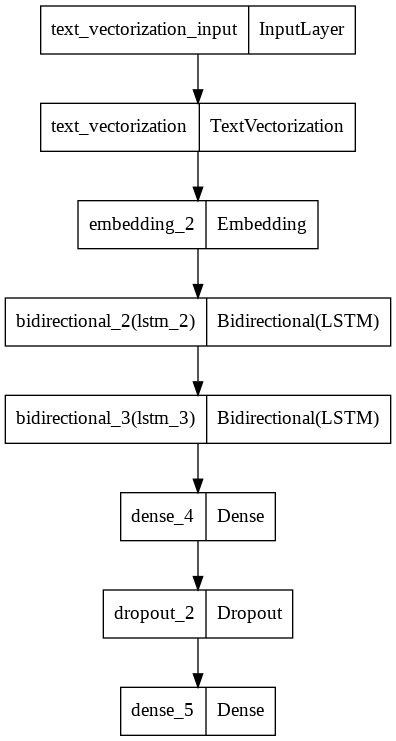

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [21]:
final_model = model.fit(train_ds, 
                        epochs=10, 
                        validation_data=test_ds,
                        validation_steps=30)

Epoch 1/10
643/643 [==============================] - 105s 137ms/step - loss: 0.7919 - accuracy: 0.6601 - val_loss: 0.6773 - val_accuracy: 0.7026
Epoch 2/10
643/643 [==============================] - 83s 129ms/step - loss: 0.6223 - accuracy: 0.7476 - val_loss: 0.6606 - val_accuracy: 0.7125
Epoch 3/10
643/643 [==============================] - 83s 129ms/step - loss: 0.6059 - accuracy: 0.7563 - val_loss: 0.6626 - val_accuracy: 0.7182
Epoch 4/10
643/643 [==============================] - 84s 130ms/step - loss: 0.5863 - accuracy: 0.7621 - val_loss: 0.6692 - val_accuracy: 0.7167
Epoch 5/10
643/643 [==============================] - 84s 130ms/step - loss: 0.5724 - accuracy: 0.7659 - val_loss: 0.6894 - val_accuracy: 0.7099
Epoch 6/10
643/643 [==============================] - 85s 132ms/step - loss: 0.5624 - accuracy: 0.7702 - val_loss: 0.6843 - val_accuracy: 0.7115
Epoch 7/10
643/643 [==============================] - 85s 132ms/step - loss: 0.5490 - accuracy: 0.7764 - val_loss: 0.7132 - val_a

(0.0, 0.8060411155223847)

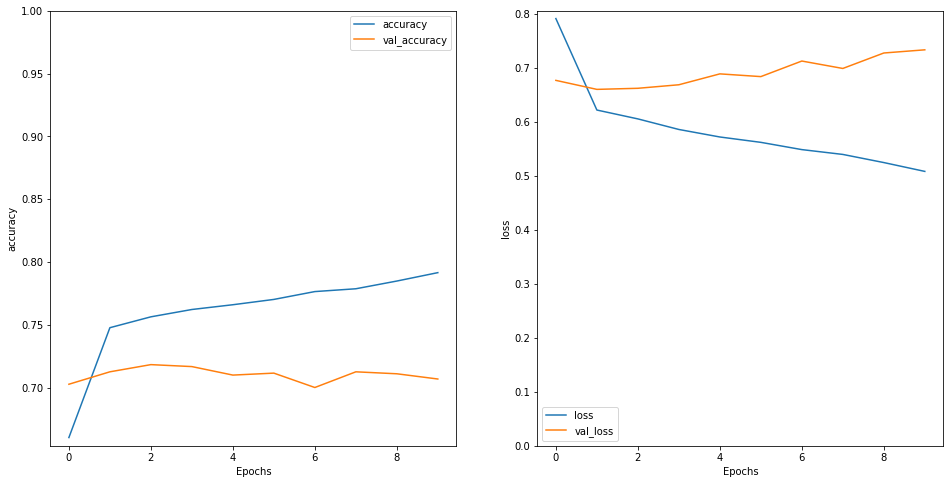

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(final_model, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(final_model, 'loss')
plt.ylim(0, None)

In [16]:
sample_text = ('love you all')
predictions = model.predict(np.array([sample_text]))
index = int(tf.math.argmax(predictions, axis=1))
print(predictions)
print(cat)
print(cat[0][index])

[[1.6787895e-03 5.5328038e-02 9.4299316e-01 1.2465585e-12 1.9492930e-13]]
[array(['Extremely Negative', 'Negative', 'Neutral', 'Positive',
       'Extremely Positive'], dtype='<U18')]
Neutral


Below is the BERT Model (Takes too long to train)

In [ ]:
pip install transformers

     |████████████████████████████████| 3.4 MB 8.7 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 3.3 MB 44.8 MB/s 
     |████████████████████████████████| 895 kB 48.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 8.3 MB/s 
     |████████████████████████████████| 1.8 MB 8.3 MB/s 
     |████████████████████████████████| 99 kB 7.2 MB/s 
     |████████████████████████████████| 352 kB 48.3 MB/s 
     |████████████████████████████████| 1.2 MB 47.1 MB/s 
     |████████████████████████████████| 90 kB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 34.6 MB/s 
     |████████████████████████████████| 47.7 MB 57 kB/s 
     |████████████████████████████████| 213 kB 60.2 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1, Total size: 115.55MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'.


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
classifier_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=5)

Epoch 1/5
643/643 [==============================] - 10531s 16s/step - loss: 1.0849 - accuracy: 0.4308 - val_loss: 1.0574 - val_accuracy: 0.4119
Epoch 2/5
342/643 [==============>...............] - ETA: 1:20:39 - loss: 1.0672 - accuracy: 0.4204